In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime

In [2]:

def calculate_adx(data, period=14):
    # Calculate the True Range (TR)
    data['TR'] = np.maximum(data['High'] - data['Low'], 
                            np.maximum(abs(data['High'] - data['Close'].shift(1)), 
                                       abs(data['Low'] - data['Close'].shift(1))))
    
    # Calculate the Plus Directional Movement (+DM) and Minus Directional Movement (-DM)
    data['+DM'] = np.where((data['High'] - data['High'].shift(1)) > (data['Low'].shift(1) - data['Low']), 
                           data['High'] - data['High'].shift(1), 0)
    data['+DM'] = np.where(data['+DM'] < 0, 0, data['+DM'])
    
    data['-DM'] = np.where((data['Low'].shift(1) - data['Low']) > (data['High'] - data['High'].shift(1)), 
                           data['Low'].shift(1) - data['Low'], 0)
    data['-DM'] = np.where(data['-DM'] < 0, 0, data['-DM'])
    
    # Calculate the smoothed TR, +DM, and -DM
    data['TR_smooth'] = data['TR'].rolling(window=period).sum()
    data['+DM_smooth'] = data['+DM'].rolling(window=period).sum()
    data['-DM_smooth'] = data['-DM'].rolling(window=period).sum()
    
    # Calculate the +DI and -DI
    data['+DI'] = 100 * (data['+DM_smooth'] / data['TR_smooth'])
    data['-DI'] = 100 * (data['-DM_smooth'] / data['TR_smooth'])
    
    # Calculate the DX
    data['DX'] = 100 * (abs(data['+DI'] - data['-DI']) / (data['+DI'] + data['-DI']))
    
    # Calculate the ADX
    data['ADX'] = data['DX'].rolling(window=period).mean()
    
    return data

# Example usage
# df = etf_data['SPY']  # Assuming you have the data loaded
# df = calculate_adx(df)

def calculate_stochastic_oscillator(data, k_period=14, d_period=3):
    # Calculate the %K
    data['L14'] = data['Low'].rolling(window=k_period).min()
    data['H14'] = data['High'].rolling(window=k_period).max()
    data['%K'] = 100 * ((data['Close'] - data['L14']) / (data['H14'] - data['L14']))
    
    # Calculate the %D
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    
    return data

# Example usage
# df = calculate_stochastic_oscillator(df)

def generate_signals(data):
    # ADX signals
    data['ADX_Buy'] = (data['ADX'] > 20) & (data['+DI'] > data['-DI'])
    data['ADX_Sell'] = (data['ADX'] > 20) & (data['-DI'] > data['+DI'])
    
    # Stochastic Oscillator signals
    data['Stoch_Buy'] = (data['%K'] < 20) & (data['%K'].shift(1) < data['%D'].shift(1)) & (data['%K'] > data['%D'])
    data['Stoch_Sell'] = (data['%K'] > 80) & (data['%K'].shift(1) > data['%D'].shift(1)) & (data['%K'] < data['%D'])
    
    return data

# Example usage
# df = generate_signals(df)

In [3]:
# List of common ETF tickers
etf_tickers = [
    'SPY',  # S&P 500 ETF
    'IVV',  # iShares Core S&P 500 ETF
    'VOO',  # Vanguard S&P 500 ETF
    'QQQ',  # Invesco QQQ Trust
    'IWM',  # iShares Russell 2000 ETF
    # Add more tickers as needed
]

# Define the start and end dates for the historical data
start_date = '2010-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Download and process data for each ETF
etf_data = {}
for ticker in etf_tickers:
    print(f"Processing data for {ticker}...")
    data = yf.download(ticker, start=start_date, end=end_date)
    data = calculate_adx(data)
    data = calculate_stochastic_oscillator(data)
    data = generate_signals(data)
    etf_data[ticker] = data

# Example: Accessing the processed data for a specific ETF
df_spy = etf_data['SPY']
print(df_spy[['ADX', '%K', '%D', 'ADX_Buy', 'ADX_Sell', 'Stoch_Buy', 'Stoch_Sell']].tail())

Processing data for SPY...


[*********************100%***********************]  1 of 1 completed


Processing data for IVV...


[*********************100%***********************]  1 of 1 completed


Processing data for VOO...


[*********************100%***********************]  1 of 1 completed


Processing data for QQQ...


[*********************100%***********************]  1 of 1 completed


Processing data for IWM...


[*********************100%***********************]  1 of 1 completed

                  ADX         %K         %D  ADX_Buy  ADX_Sell  Stoch_Buy  \
Date                                                                        
2024-10-21  37.317436  88.057587  87.545984     True     False      False   
2024-10-22  38.390175  86.427595  89.049065     True     False      False   
2024-10-23  38.071093  58.286255  77.590479     True     False      False   
2024-10-24  36.454623  64.699803  69.804551     True     False      False   
2024-10-25  37.249585  57.323498  60.103185     True     False      False   

            Stoch_Sell  
Date                    
2024-10-21       False  
2024-10-22        True  
2024-10-23       False  
2024-10-24       False  
2024-10-25       False  


In [4]:
# Plotting function
def plot_indicators(data, ticker):
    plt.figure(figsize=(14, 10))

    # Plot Close Price
    plt.subplot(3, 1, 1)
    plt.plot(data.index, data['Close'], label='Close Price')
    plt.title(f'{ticker} Close Price and Buy/Sell Signals')
    plt.scatter(data.index[data['ADX_Buy']], data['Close'][data['ADX_Buy']], marker='^', color='g', label='ADX Buy', alpha=1)
    plt.scatter(data.index[data['ADX_Sell']], data['Close'][data['ADX_Sell']], marker='v', color='r', label='ADX Sell', alpha=1)
    plt.legend()

    # Plot ADX
    plt.subplot(3, 1, 2)
    plt.plot(data.index, data['ADX'], label='ADX', color='b')
    plt.axhline(20, color='gray', linestyle='--', linewidth=0.5)
    plt.title('ADX Indicator')
    plt.legend()

    # Plot Stochastic Oscillator
    plt.subplot(3, 1, 3)
    plt.plot(data.index, data['%K'], label='%K', color='c')
    plt.plot(data.index, data['%D'], label='%D', color='m')
    plt.axhline(20, color='gray', linestyle='--', linewidth=0.5)
    plt.axhline(80, color='gray', linestyle='--', linewidth=0.5)
    plt.title('Stochastic Oscillator')
    plt.scatter(data.index[data['Stoch_Buy']], data['%K'][data['Stoch_Buy']], marker='^', color='g', label='Stoch Buy', alpha=1)
    plt.scatter(data.index[data['Stoch_Sell']], data['%K'][data['Stoch_Sell']], marker='v', color='r', label='Stoch Sell', alpha=1)
    plt.legend()

    plt.tight_layout()
    plt.show()

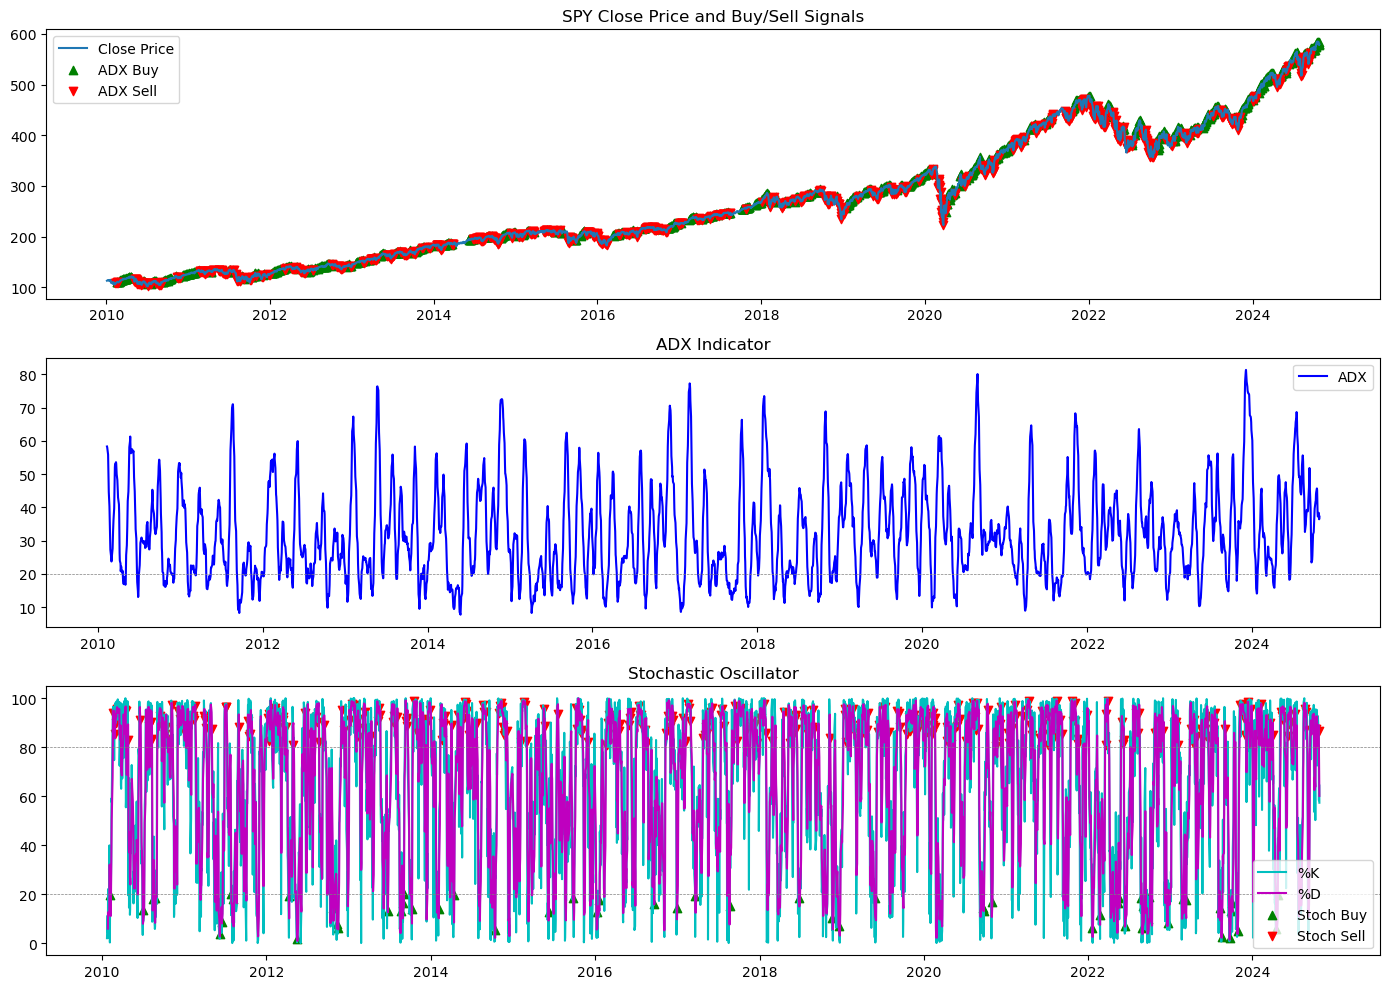

In [5]:
# Example: Plot indicators for SPY
plot_indicators(etf_data['SPY'], 'SPY')

In [6]:
def backtest_strategy(data, initial_capital=10000, transaction_cost=0.001):
    cash = initial_capital
    holdings = 0
    portfolio_values = [initial_capital]  # Start with initial capital

    for i in range(1, len(data)):
        if data['ADX_Buy'].iloc[i] or data['Stoch_Buy'].iloc[i]:
            if cash > 0:
                # Buy signal
                trade_value = cash * (1 - transaction_cost)
                holdings = trade_value / data['Close'].iloc[i]
                cash = 0
        
        elif data['ADX_Sell'].iloc[i] or data['Stoch_Sell'].iloc[i]:
            if holdings > 0:
                # Sell signal
                trade_value = holdings * data['Close'].iloc[i] * (1 - transaction_cost)
                cash = trade_value
                holdings = 0
        
        # Calculate portfolio value
        portfolio_value = cash + holdings * data['Close'].iloc[i]
        portfolio_values.append(portfolio_value)

    # Calculate daily returns
    if len(portfolio_values) > 1:
        daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    else:
        daily_returns = np.array([0])

    # Calculate performance metrics
    total_return = (portfolio_values[-1] - initial_capital) / initial_capital
    annualized_return = (1 + total_return) ** (252 / len(data)) - 1 if len(data) > 0 else 0
    max_drawdown = (np.max(portfolio_values) - np.min(portfolio_values)) / np.max(portfolio_values) if np.max(portfolio_values) > 0 else 0
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252) if np.std(daily_returns) > 0 else 0

    return total_return, annualized_return, max_drawdown, sharpe_ratio, portfolio_values

In [7]:
# # Example: Backtest strategy for SPY
backtest_strategy(etf_data['SPY'])

(0.11425717394058574,
 0.007337966127132001,
 0.3339688871193145,
 0.1230177933653131,
 [10000,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  9990.0,
  9917.879782319776,
  10042.450547705532,
  10022.781592315956,
  10117.55500503929,
  10117.55500503929,
  10117.55500503929,
  10117.55500503929,
  10107.437450034251,
  10128.397393710371,
  10130.22042072287,
  9997.184630956674,
  9997.184630956674,
  9987.187446325717,
  9993.504425497686,
  10097.283959179254,
  10125.259054298105,
  10134.28390040014,
  10164.966173949962,
  10310.25738340434,
  10312.061939525292,
  10329.208320920246,
  10375.232419744074,
  10418.548651637835,
  10419.451273947856,
  10422.15845237883,
  10505.18249242354,
  10567.449661833207,
  10562.035304971261,
  10465.475372771683,
  10521.425563009381,
  1059

In [8]:
def optimize_parameters(data, adx_periods, stoch_k_periods, stoch_d_periods):
    results = []

    for adx_period in adx_periods:
        for k_period in stoch_k_periods:
            for d_period in stoch_d_periods:
                # Calculate indicators
                data = calculate_adx(data, period=adx_period)
                data = calculate_stochastic_oscillator(data, k_period=k_period, d_period=d_period)
                data = generate_signals(data)

                # Backtest strategy
                _, _, _, sharpe_ratio, _ = backtest_strategy(data)

                # Store results
                results.append((adx_period, k_period, d_period, sharpe_ratio))

    return results

Best Parameters: ADX Period: 90.0, Stochastic K Period: 20.0, Stochastic D Period: 3.0
Best Sharpe Ratio: 0.69


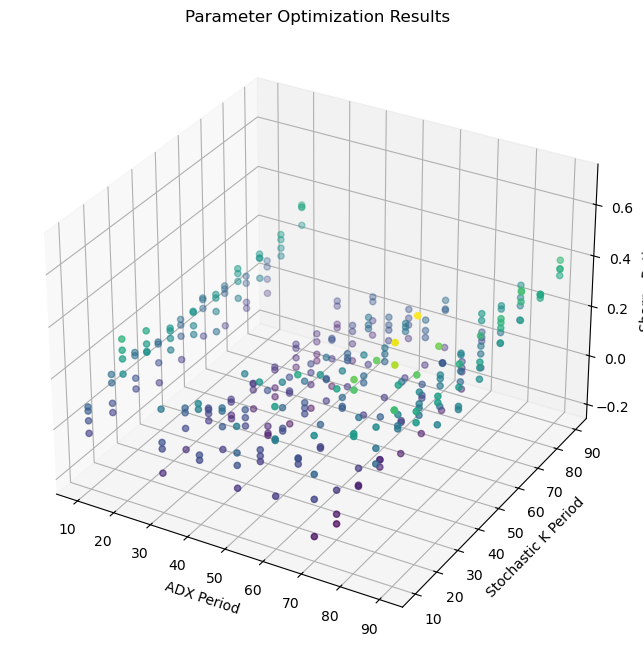

In [9]:
# Example: Optimize parameters for SPY
adx_periods = range(10, 100, 10)
stoch_k_periods = range(10, 100, 10)
stoch_d_periods = range(3, 7, 1)

results = optimize_parameters(etf_data['SPY'], adx_periods, stoch_k_periods, stoch_d_periods)

# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(results, columns=['ADX Period', 'Stoch K Period', 'Stoch D Period', 'Sharpe Ratio'])

# Find the best parameters
best_result = results_df.loc[results_df['Sharpe Ratio'].idxmax()]

print(f"Best Parameters: ADX Period: {best_result['ADX Period']}, Stochastic K Period: {best_result['Stoch K Period']}, Stochastic D Period: {best_result['Stoch D Period']}")
print(f"Best Sharpe Ratio: {best_result['Sharpe Ratio']:.2f}")

# Plot the results
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D scatter plot
ax.scatter(results_df['ADX Period'], results_df['Stoch K Period'], results_df['Sharpe Ratio'], c=results_df['Sharpe Ratio'], cmap='viridis', marker='o')

ax.set_xlabel('ADX Period')
ax.set_ylabel('Stochastic K Period')
ax.set_zlabel('Sharpe Ratio')
ax.set_title('Parameter Optimization Results')

plt.show()

Best Parameters: ADX Period: 90, Stochastic K Period: 20, Stochastic D Period: 3
Best Sharpe Ratio: 0.69


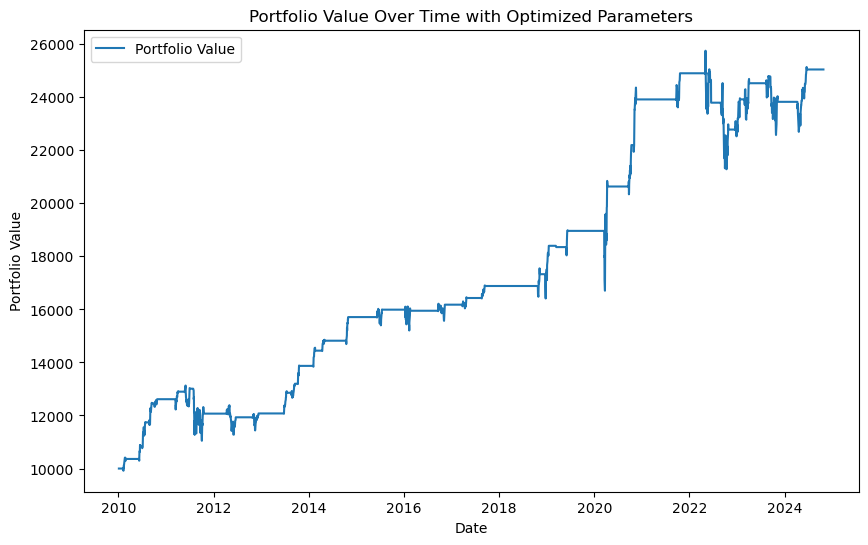

In [10]:
# Example: Optimize parameters for SPY
results = optimize_parameters(etf_data['SPY'], adx_periods, stoch_k_periods, stoch_d_periods)

# Find the best parameters
best_params = max(results, key=lambda x: x[3])
best_adx_period, best_k_period, best_d_period, best_sharpe = best_params

print(f"Best Parameters: ADX Period: {best_adx_period}, Stochastic K Period: {best_k_period}, Stochastic D Period: {best_d_period}")
print(f"Best Sharpe Ratio: {best_sharpe:.2f}")

# Backtest with the best parameters
data = calculate_adx(etf_data['SPY'], period=best_adx_period)
data = calculate_stochastic_oscillator(data, k_period=best_k_period, d_period=best_d_period)
data = generate_signals(data)
_, _, _, _, portfolio_values = backtest_strategy(data)

# Ensure the lengths match
if len(data.index) != len(portfolio_values):
    print("Warning: Data index and portfolio values length mismatch. Adjusting for plotting.")
    min_length = min(len(data.index), len(portfolio_values))
    data = data.iloc[:min_length]
    portfolio_values = portfolio_values[:min_length]

# Plot the portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(data.index, portfolio_values, label='Portfolio Value')
plt.title('Portfolio Value Over Time with Optimized Parameters')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

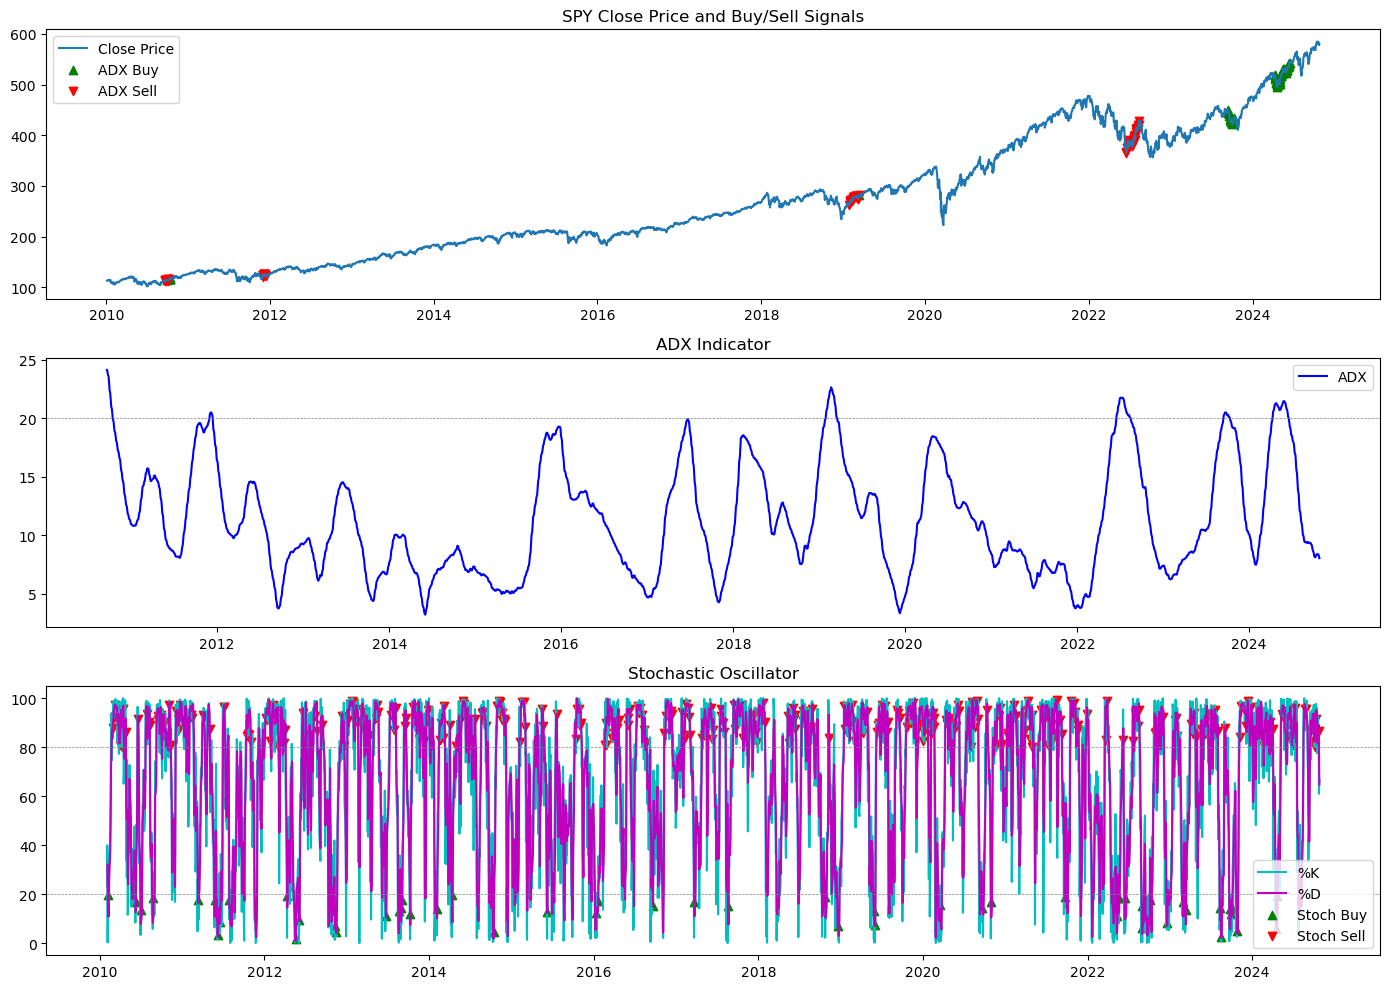

In [11]:
# Assuming you have already optimized and found the best parameters
best_adx_period, best_k_period, best_d_period, _ = best_params

# Calculate indicators with the best parameters
data = calculate_adx(etf_data['SPY'], period=best_adx_period)
data = calculate_stochastic_oscillator(data, k_period=best_k_period, d_period=best_d_period)
data = generate_signals(data)

# Plot the indicators
plot_indicators(data, 'SPY')